In [1]:
import collections
import numpy as np
import tskit
import sys
sys.path.append("../")
import sc2ts

In [2]:
# Generate these trees by running pytest tests/test_inference.py
ts_file = "../tests/data/cache/2020-02-13.ts"
ts = tskit.load(ts_file)
ts


In [3]:
mut_labels = {}
mut_pos = []
mut_types = []

for mut in ts.mutations():
    site = ts.site(mut.site)
    pos = int(site.position)
    older_mut = mut.parent >= 0
    prev = ts.mutation(mut.parent).derived_state if older_mut else site.ancestral_state
    mut_labels[mut.id] = f"{prev}{pos}{mut.derived_state}"
    mut_pos.append(pos)
    mut_types.append(f"{prev}{mut.derived_state}")


collections.Counter(mut_types)


Counter({'CT': 38,
         'GT': 10,
         'AG': 7,
         'TC': 7,
         'GA': 4,
         'A-': 4,
         'T-': 1,
         'TA': 1,
         'GC': 1,
         'CA': 1,
         'C-': 1,
         'G-': 1})

In [4]:
# There is one site having two mutations.
mut_pos_counts = collections.Counter(mut_pos)
for k, v in mut_pos_counts.items():
    if v > 1:
        print(f"pos: {k}; count: {v}")


pos: 26144; count: 2
pos: 29742; count: 2


In [5]:
# The majority of samples should be from the lineage B, with some from the lineage A.
node_labels = {}
pango_labels = []
for node in ts.nodes():
    if node.is_sample() and "Viridian_pangolin" in node.metadata:
        strain = node.metadata["strain"]
        pango = node.metadata["Viridian_pangolin"]
        node_labels[node.id] = f"{node.id} {pango}\n{strain}"
        pango_labels.append(pango)
    else:
        node_labels[node.id] = f"{node.id}"
collections.Counter(pango_labels)


Counter({'B': 19, 'A': 12, 'B.1': 4, 'B.40': 2, 'B.4': 1, 'B.33': 1})

In [6]:
# Check polytomy at the top.
ts.first().num_children_array


array([ 1, 13,  0,  0,  0,  2,  1, 10,  0,  0,  0,  0,  0,  0,  0,  0,  4,
        0,  0,  0,  0,  0,  2,  0,  0,  0,  0,  2,  0,  0,  2,  0,  0,  0,
        2,  0,  0,  0,  2,  4,  0,  0,  0,  0,  2,  0,  2,  1,  0,  0,  0,
        0,  2,  1], dtype=int32)

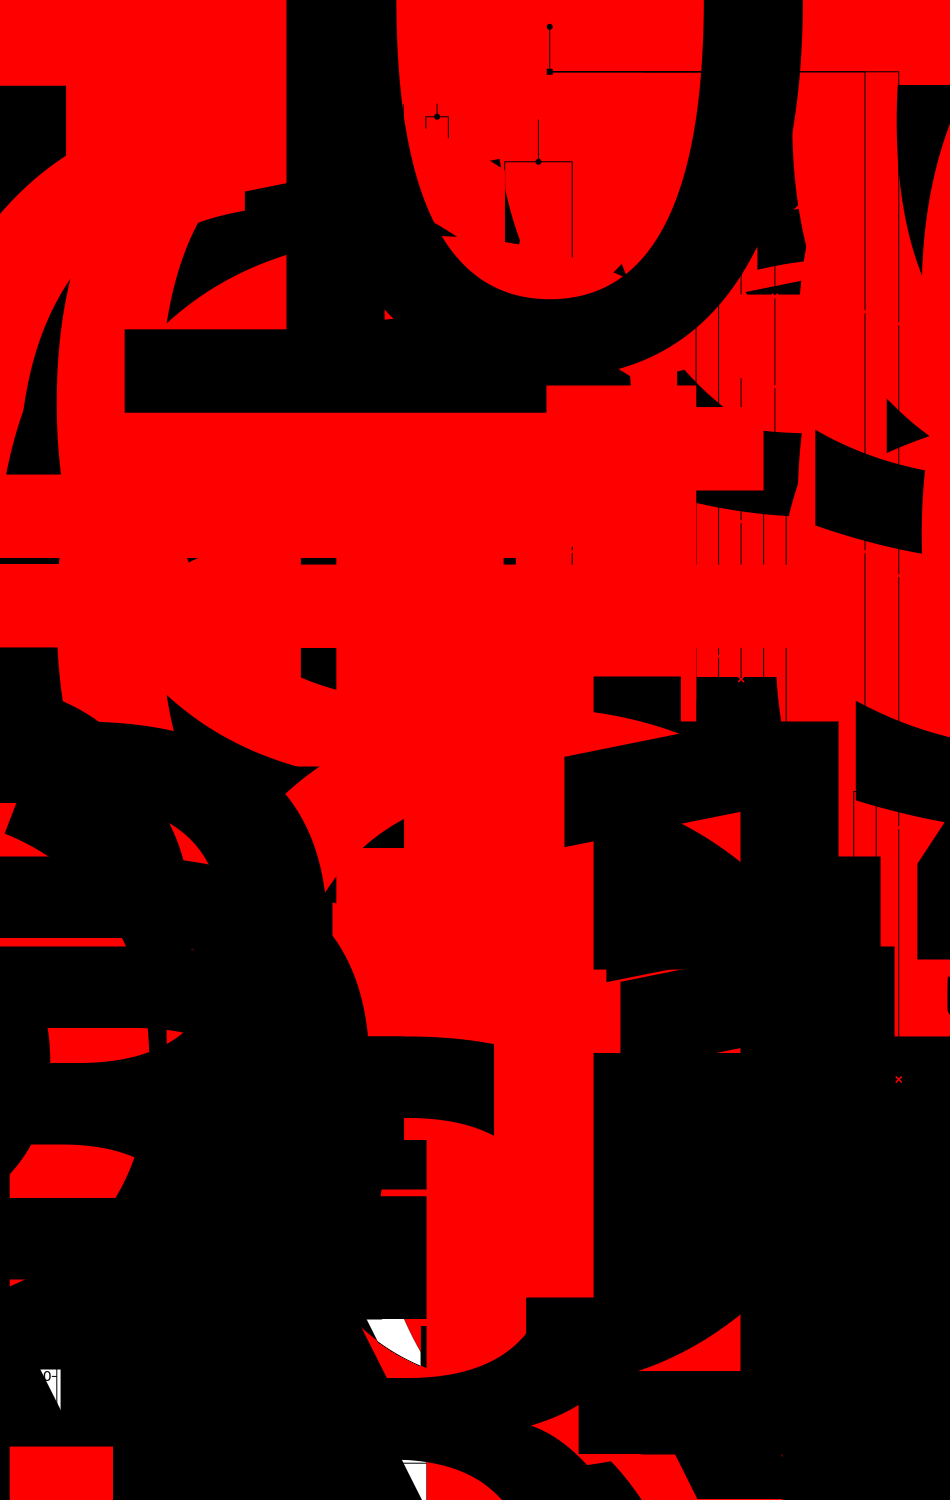

In [7]:
# Note that lineages A and B are characterised by differences at two site positions: 8782 and 28144.
# Lineage B samples have 8782C and 28144T, whereas lineage A samples have 8782T and 28144C.
# 
# The reference Wuhan-Hu-1 belongs to lineage B, and is arbitrarily chosen as the root here.
# So, we should expect to see samples from lineage A grouped by two mutations: C8782T and T28144C.
label_style = (
    ".mut > .lab {font-size: 80%; transform: rotate(-25deg) translate(0px)}"
    ".node > .lab {font-size: 80%}"
    ".leaf > .lab {text-anchor: middle; transform: rotate(-35deg) translateY(10px)}"
)

ts.draw_svg(
    node_labels=node_labels,
    mutation_labels=mut_labels,
    y_axis=True,
    time_scale="rank",
    x_scale="treewise",
    size=(950, 1500),
    style=label_style,
)


## Constructing a recombinant

Pick two samples with mutations on opposite sides of the sequence, and create a franken-haplotype

In [8]:
for u in [51, 36]:
    print(ts.node(u).metadata["strain"])

ERR4206593
SRR11597178


In [9]:
def mutations_on_path(u, v):
    tree = ts.first()
    mutations = []
    while u != v:
        for mut_id in np.where(ts.mutations_node == u)[0]:
            mut = ts.mutation(mut_id)
            pos = int(ts.sites_position[mut.site])
            mutations.append((pos, mut.derived_state))
        u = tree.parent(u)
    return sorted(mutations)
    

In [10]:
strains = ["SRR11597188", "SRR11597163"]
for strain in strains:
    u = ts.samples()[ts.metadata["sc2ts"]["samples_strain"].index(strain)]
    print(strain, u, mutations_on_path(u, 1), sep="\t")

SRR11597188	31	[(871, 'G'), (3027, 'G'), (3787, 'T'), (11083, 'T')]
SRR11597163	45	[(15324, 'T'), (29303, 'T')]


# TreeInfo

In [11]:
ti = sc2ts.TreeInfo(ts)
ti

Classifying mutations: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76/76 [00:00<00:00, 79911.53it/s]


,value
property,
latest_sample,2020-02-13
samples,40
nodes,53
exact_matches,0
mc_nodes,4
pr_nodes,3
re_nodes,0
imr_nodes,0
mutations,76


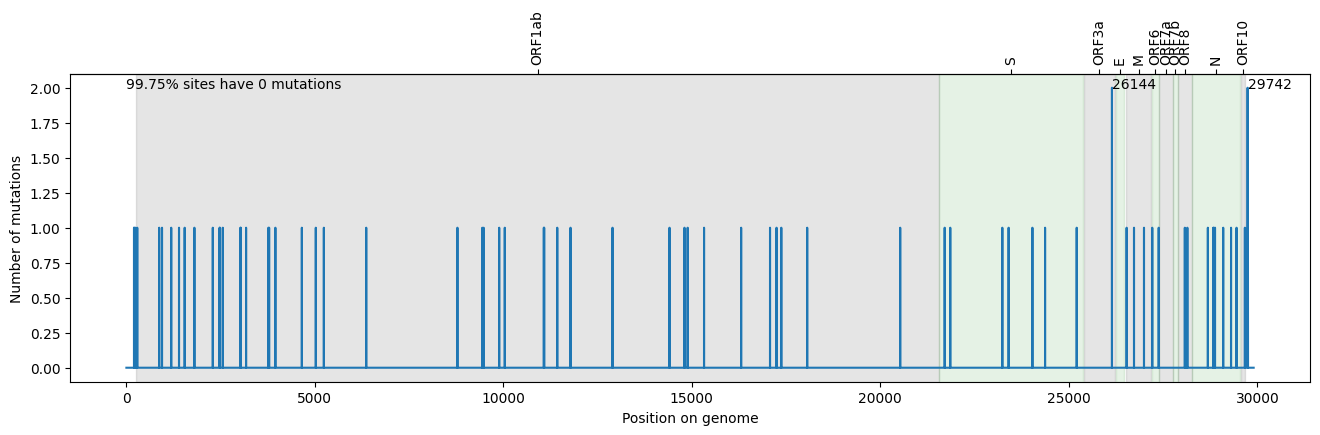

In [22]:
ti.plot_mutations_per_site();

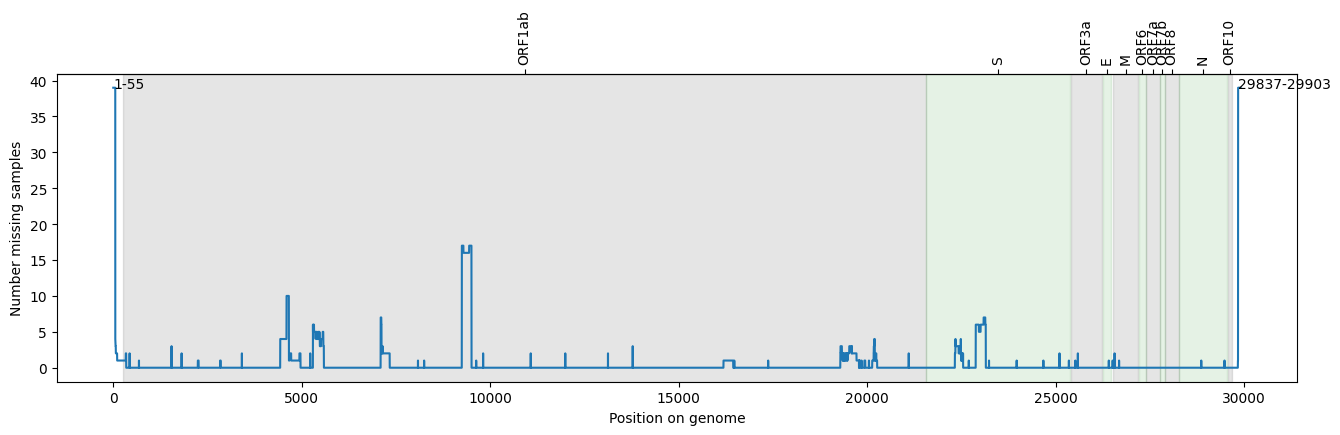

In [23]:
ti.plot_missing_samples_per_site();

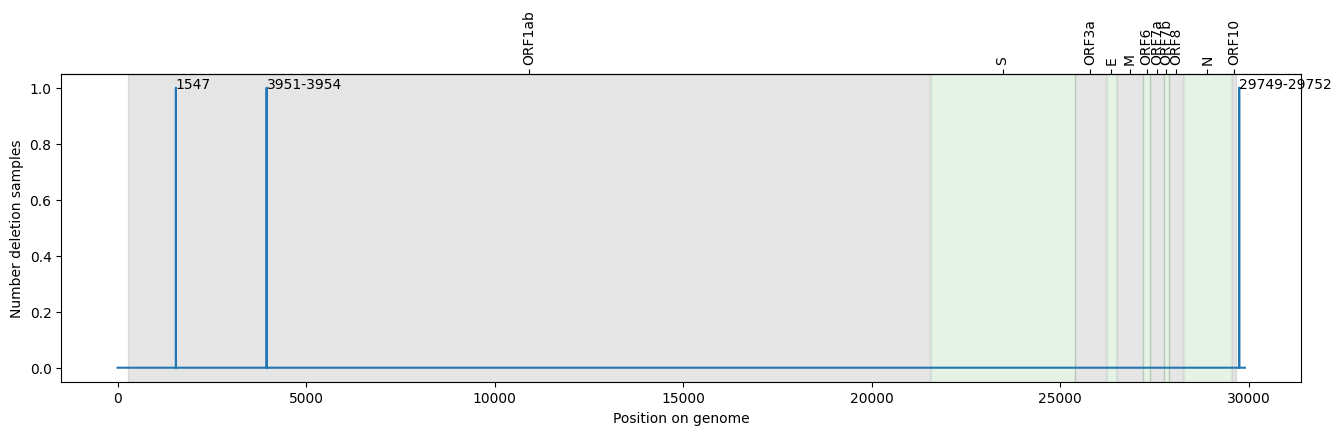

In [24]:
ti.plot_deletion_samples_per_site();

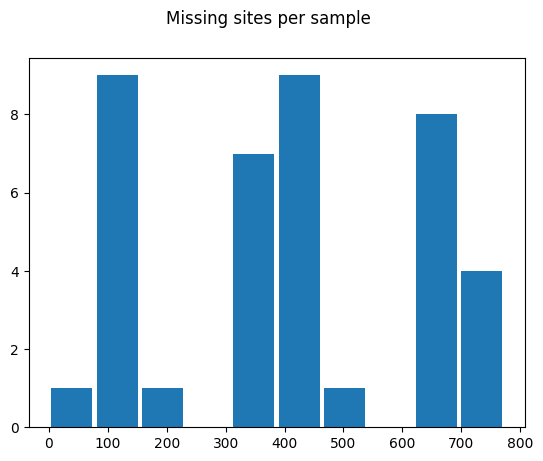

In [25]:
ti.plot_missing_sites_per_sample();

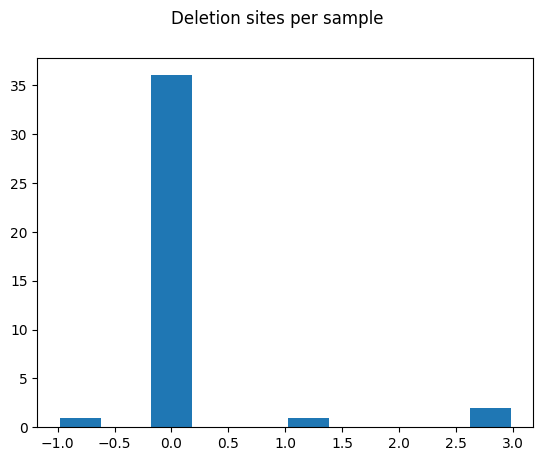

In [26]:
ti.plot_deletion_sites_per_sample();

# Deletions

We have 3 deletion events

In [28]:
ti.deletions_summary()

,start,node,length,max_inheritors,min_inheritors
0,1547,24,1,1,1
1,3951,25,3,1,1
2,29749,49,3,1,1


In [29]:
for u in ts.samples()[1:]:
    md = ti.nodes_metadata[u]
    if "-" in md["sc2ts"]["alignment_composition"]:
        md = ti.nodes_metadata[u]
        print(md["strain"], md["date"])
    #print(ti.nodes_metadata[u]["sc2ts"]["num_deletion_sites"])

SRR11597164 2020-02-02
SRR11597190 2020-02-02
SRR11597218 2020-02-11


# Missing data

In [19]:
for u in ts.samples()[1:]:
    md = ti.nodes_metadata[u]
    if md["sc2ts"]["num_missing_sites"] > 0:
        print(md["strain"], md["date"], md["sc2ts"]["num_missing_sites"] )
    #print(ti.nodes_metadata[u]["sc2ts"]["num_deletion_sites"])

SRR11772659 2020-01-19 121
SRR11397727 2020-01-24 693
SRR11397730 2020-01-24 667
SRR11597198 2020-01-25 378
SRR11597143 2020-01-28 378
SRR11597154 2020-01-28 620
SRR11597121 2020-01-29 378
SRR11597220 2020-01-29 631
SRR12162232 2020-01-30 427
SRR12162233 2020-01-30 121
SRR12162234 2020-01-30 121
SRR12162235 2020-01-30 474
SRR11494548 2020-01-31 644
SRR11597140 2020-02-01 444
SRR11597151 2020-02-01 351
SRR11597144 2020-02-01 457
SRR11597153 2020-02-01 186
SRR11597114 2020-02-02 402
SRR11597164 2020-02-02 122
SRR11597190 2020-02-02 123
SRR11597195 2020-02-02 441
ERR4239266 2020-02-03 678
SRR11597191 2020-02-03 122
SRR11597188 2020-02-04 378
SRR11597136 2020-02-04 773
SRR11597175 2020-02-04 403
SRR11597168 2020-02-06 724
SRR11597178 2020-02-06 626
SRR11597196 2020-02-06 378
SRR11597146 2020-02-07 121
SRR11597150 2020-02-07 378
SRR11397718 2020-02-08 421
SRR11397722 2020-02-08 404
SRR11597163 2020-02-08 441
ERR4206180 2020-02-09 680
SRR11597116 2020-02-10 749
SRR11597218 2020-02-11 122
ERR

## Samples with one mutation

In [40]:
def samples_k_mutations(k):
    s = ts.samples()[ti.nodes_num_mutations[ts.samples()] == k]
    for u in s:
        md = ti.nodes_metadata[u]
        hmm = md["sc2ts"]["hmm_match"]
        muts = hmm["mutations"]
        if len(muts) == k:
            print(md["date"], md["strain"], hmm["path"][0]["parent"], muts)
samples_k_mutations(1)

2020-01-28 SRR11597154 1 [{'derived_state': 'T', 'inherited_state': 'C', 'site_position': 24370}]
2020-02-01 SRR11597151 7 [{'derived_state': 'A', 'inherited_state': 'T', 'site_position': 9477}]
2020-02-07 SRR11597146 7 [{'derived_state': 'T', 'inherited_state': 'C', 'site_position': 29095}]
2020-02-13 ERR4206593 47 [{'derived_state': 'T', 'inherited_state': 'C', 'site_position': 26994}]


In [41]:
samples_k_mutations(2)

2020-01-29 SRR11597121 7 [{'derived_state': 'T', 'inherited_state': 'C', 'site_position': 3176}, {'derived_state': 'T', 'inherited_state': 'C', 'site_position': 21855}]
2020-01-31 SRR11494548 7 [{'derived_state': 'G', 'inherited_state': 'A', 'site_position': 2476}, {'derived_state': 'T', 'inherited_state': 'C', 'site_position': 29743}]
2020-02-02 SRR11597164 1 [{'derived_state': '-', 'inherited_state': 'A', 'site_position': 1547}, {'derived_state': 'T', 'inherited_state': 'G', 'site_position': 28845}]


In [21]:
ti.num_samples_per_day

array([2, 0, 1, 1, 1, 3, 2, 3, 0, 3, 2, 4, 4, 1, 4, 2, 2, 0, 0, 1, 2, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1])

## Sample groups

In [31]:
ti.nodes_sample_group

defaultdict(list,
            {'02984ed831cd3c72d206959449dcf8c9': [2],
             '0c36395a702379413ffc855f847873c6': [3, 4, 5],
             '0304e873adb30c03ead03feb5d9459dd': [6],
             'f022f1ca5ae33e8070543a74d32004e9': [8, 9],
             'c0eece00f46737b2235837eda8510b7f': [10],
             'e89378588d904e79a650cd06fc6d5f25': [11],
             '9d00e2a016661caea4c2d9abf83375b8': [12, 13, 14, 15, 16],
             'b4cbb74c08a70aed3215081fef405bac': [17],
             'c29e00fb309f9012a3ca86f6a245d50b': [18, 19],
             'c0b5a49fc7a33c33a09bd655b7f16cd5': [20, 21, 22],
             'fc2507ade37c3646c29908ef332c4f03': [23, 24, 25],
             'a54704e412436ca373b6b0d5f5fb0835': [26],
             'bfb6a904119bb7ac635c5ee7331eecb8': [28],
             'efc7ca26a7b77a53184c37ec4fb5067c': [29],
             '893f3cd6ce72de0bf8298100e2d106a1': [31, 32, 33, 34],
             '36ad90f6ebd50bd450a617fb9652e1dc': [35, 36],
             'd05154e403c26fa83e65ecd5ef1571e